# Parametric functions

**Coding party OpenTURNS, march 2023**

Michaël Baudin

Mathieu Couplet

## Abstract

In many cases, the G function has parameters:

* Numerical parameters: mecanical parameters (e.g. Young modulus), fluid (e.g. viscosity), geometric (e.g. length), etc.
* Integer parameters: choice of a numerical method, choice of the physical model, etc.
* Computer parameters: path to a directory, to a file, etc.

Ces paramètres ne sont pas des variables aléatoires : on ne veut pas les
faire varier.

In this Notebook, we experiment with two classes:

* `ParametricFunction`
* `OpenTURNSPythonFunction`

## References

* Ishigami, T., & Homma, T. (1990, December). An importance quantification technique in uncertainty analysis for computer models. In Uncertainty Modeling and Analysis, 1990. Proceedings., First International Symposium on (pp. 398-403). IEEE.
* http://openturns.github.io/openturns/master/examples/functional_modeling/parametric_function.html
* http://openturns.github.io/openturns/master/user_manual/_generated/openturns.ParametricFunction.html
* http://openturns.github.io/openturns/master/user_manual/_generated/openturns.Function.html
* http://openturns.github.io/openturns/master/user_manual/_generated/openturns.OpenTURNSPythonFunction.html


## Example

We consider the Ishigami model.


In [1]:
import openturns as ot
import openturns.viewer as otv
import math

In [2]:
def ishigamiG(x):
    a = 7.0
    b = 0.1
    y = math.sin(x[0]) + a * math.sin(x[1]) ** 2 + b * x[2] ** 4 * math.sin(x[0])
    return [y]


myWrapper = ot.PythonFunction(3, 1, ishigamiG)

p = math.pi / 2
X = [p, p, p]
myWrapper(X)

class=Point name=Unnamed dimension=1 values=[8.60881]

We would like to change the values of `a` and `b`: that is impossible, because these parameters are hard coded.

## ParametricFunction

The simplest solution is to use the `ParametricFunction`.

We proceed in two steps. 

**Step 1:** Increase the input dimension so that `a` and `b` are part of the input.


In [3]:
def ishigamiG(x):
    a = x[3]
    b = x[4]
    y = math.sin(x[0]) + a * math.sin(x[1]) ** 2 + b * x[2] ** 4 * math.sin(x[0])
    return [y]


myParamWrapper = ot.PythonFunction(5, 1, ishigamiG)

X = [p, p, p, 7.0, 0.1]
myParamWrapper(X)

class=Point name=Unnamed dimension=1 values=[8.60881]

**Step 2:** Restrict the number of inputs to `x1`, `x2` and `x3` and set `a` and `b` as parameters.

Each variable corresponds to a particular index of the input vectory `x`. Furthermore, we must take into account that Python indices start from 0. The next table presents the mapping. 

| Variable | Index |
|---|---|
| `x1` | 0 |
| `x2` | 1 |
| `x3` | 2 |
| `a` | 3 |
| `b` | 4 |

**Table 1.** Mapping from the variable name to its index in the Python function. 

Since the variables `a` and `b` correspond to the indices 3 and 4 of `x`. This explains why the next cell defines the `indices` variable with the corresponding indices. 

In [4]:
a = 7.0
b = 0.1
indices = [3, 4]
refPoint = [a, b]
myWrapper = ot.ParametricFunction(myParamWrapper, indices, refPoint)

Now the parametric function `myWrapper` takes an input point with dimension 3: the parameters `a` and `b` are set to constant values. 

In [5]:
X = [p, p, p]
myWrapper(X)

class=Point name=Unnamed dimension=1 values=[8.60881]

The `getParameter()` method returns the values of the parameters. 

In [6]:
myWrapper.getParameter()

class=Point name=Unnamed dimension=2 values=[7,0.1]

The `getParameterDimension()` method returns the dimension of the parameter point. 

In [7]:
myWrapper.getParameterDimension()

2

We can change the values of the parameters using the `setParameter()` method.

In [8]:
myWrapper.setParameter([8.0, 0.2])

## Use a ParametricFunction in calibration

The `ParametricFunction` is used in calibration algorithms, such as the `LinearLeastSquaresCalibration` or `RandomWalkMetropolisHastings` for example. This is because these algorithms tune the parameters of the parametric function so that the output of the function get closer to observed values. 

In calibration classes, the function has the calling sequence:

$$
y = h(x, \theta)
$$

where $h$ is the model, $x$ is the observed input, $\theta$ is the parameter and $y$ is the output.

We must pay attention to the fact that each calibration class uses the `ParametricFunction` with its own way: the implementation of the mathematical idea is done differently depending on the class. 

- `LinearLeastSquaresCalibration`, `NonLinearLeastSquaresCalibration`, `GaussianLinearCalibration`, `GaussianNonLinearCalibration`: the parameter $\theta$ is the parameter and the input of the function is $x$. The parametric function is $y = h_{\theta}(x)$.
- `RandomWalkMetropolisHastings`: the parameter $\theta$ is the input and the parameter of the function is $x$. The parametric function is $y = h_{x}(\theta)$.

## Advantages and limitations of the ParametricFunction

If the function only has floating point number parameters and that the number of parameters is relatively small and homogeneous, then the `ParametricFunction` is the right tool. If the function has parameters which are not floating point numbers or when the number of parameters is large or heterogeneous, then the `ParametricFunction` is not easy to manage. In this case, the `OpenTURNSPythonFunction` class is more easy to use.

## OpenTURNSPythonFunction 

The `OpenTURNSPythonFunction` is the most exciting class to create a `Function`. Indeed, it allows to create a function which is based on a `Class`. Hence, 

**Step 1:** create the class.

In the next cell, we define the Ishigami function using a class. The constructor, implemented in the `__init__`, has two inputs `a` and `b`. The body of the class calls the `super` function to evaluate the constructor of the parent `OpenTURNSPythonFunction` class. This constructor takes the input (here, 3) and output (here, 1) as input parameters. Then the parameters `a` and `b` are stored as attributes of the class. 

It is important to notice that we can take into account any number of input arguments in the constructor, and that these arguments are not necessarily floating point numbers: they can be any type of Python object, including strings, lists, etc. Moreover, there can be optional input arguments with default values. These features make a huge difference with the `ParametricFunction`, which can only take into account for a `Point` parameter, i.e. a sequence of floating point numbers.

The evaluation of the function is performed in the `_exec` method of the class.

In [9]:
class IshigamiFunction(ot.OpenTURNSPythonFunction):
    def __init__(self, a, b):
        super(IshigamiFunction, self).__init__(3, 1)
        self._a = a
        self._b = b

    def _exec(self, X):
        a = self._a
        b = self._b
        y = math.sin(X[0]) + a * math.sin(X[1]) ** 2 + b * X[2] ** 4 * math.sin(X[0])
        return [y]

**Step 2:** Create a function.

The object created from the `IshigamiFunction` cannot be evaluated directly: we must create a `Function` from it.

In [10]:
a = 7.0
b = 0.1
myParametricWrapper = IshigamiFunction(a, b)
myWrapper = ot.Function(myParametricWrapper)

Then the function can be used as any other function.

In [11]:
X = [p, p, p]
myWrapper(X)

class=Point name=Unnamed dimension=1 values=[8.60881]

## Conclusion

`ParametricFunction`:

* simple ;
* any `Function` can be parametric: symbolic, Python, ;
* manages floating point numbers (no integer, string, etc.).

`OpenTURNSPythonFunction` :

* a little more complicated ;
* only for a Python function ;
* manages an arbitrary number and type of parameters.


## Exercises

The following function is an implementation of the flooding test case.


In [12]:
def functionCrue(X):
    H_d = 3.0  # Height of the dyke
    Z_b = 55.5  # Height of the side of the river
    L = 5000.0  # Length of the river
    B = 300.0  # Width of the river
    Z_d = Z_b + H_d
    Q, K_s, Z_v, Z_m = X
    alpha = (Z_m - Z_v) / L
    H = (Q / (K_s * B * sqrt(alpha))) ** (3.0 / 5.0)
    Z_c = H + Z_v
    S = Z_c - Z_d
    return [S]


myWrapper = ot.PythonFunction(4, 1, functionCrue)

The parameters `H_d`, `Z_b`, `L`, `B` are hard-coded in `functionCrue`. In the next exercises, we experiment several methods to customize the parameters `H_d`, `Z_b`, `L`, `B`.

### Exercise 1

Use the `ParametricFunction` on the flooding model.

### Solution of exercise 1

In [13]:
def drawHistogram(myWrapper):
    # 2. Random vector definition
    Q = ot.Gumbel(558.0, 1013.0)
    Q = ot.TruncatedDistribution(Q, 0.0, ot.TruncatedDistribution.LOWER)
    K_s = ot.Normal(30.0, 7.5)
    K_s = ot.TruncatedDistribution(K_s, 0.0, ot.TruncatedDistribution.LOWER)
    Z_v = ot.Uniform(49.0, 51.0)
    Z_m = ot.Uniform(54.0, 56.0)

    # 3. Create the joint distribution function,
    #    the output and the event.
    inputDistribution = ot.ComposedDistribution([Q, K_s, Z_v, Z_m])
    inputRandomVector = ot.RandomVector(inputDistribution)
    outputRandomVector = ot.CompositeRandomVector(myWrapper, inputRandomVector)

    # 4. Get a sample of the output
    sampleS = outputRandomVector.getSample(10000)

    # 5. Plot the histogram
    histoGraph = ot.HistogramFactory().build(sampleS).drawPDF()
    histoGraph.setTitle("Overflow")
    histoGraph.setXTitle("S (m)")
    histoGraph.setYTitle("PDF")
    histoGraph.setLegends([""])
    return histoGraph

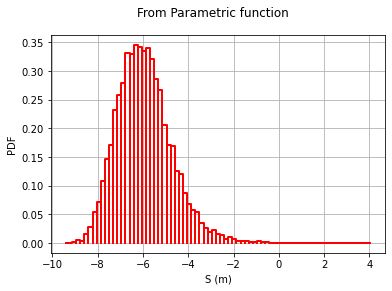

In [14]:
def floodingFullFunction(X):
    Q, K_s, Z_v, Z_m, H_d, Z_b, L, B = X
    Z_d = Z_b + H_d
    alpha = (Z_m - Z_v) / L
    H = (Q / (K_s * B * math.sqrt(alpha))) ** (3.0 / 5.0)
    Z_c = H + Z_v
    S = Z_c - Z_d
    return [S]


myFullFunction = ot.PythonFunction(8, 1, floodingFullFunction)

H_d = 3.0  # Height of the dyke
Z_b = 55.5  # Height of the side of the river
L = 5000.0  # Length of the river
B = 300.0  # Width of the river

indices = [4, 5, 6, 7]
referencePoint = [H_d, Z_b, L, B]
myParametricFlooding = ot.ParametricFunction(myFullFunction, indices, referencePoint)

histoGraph = drawHistogram(myParametricFlooding)
histoGraph.setTitle("From Parametric function")
view = otv.View(histoGraph)

### Exercise 2

Use the `OpenTURNSPythonFunction` on the flooding model.


### Solution of exercise 2

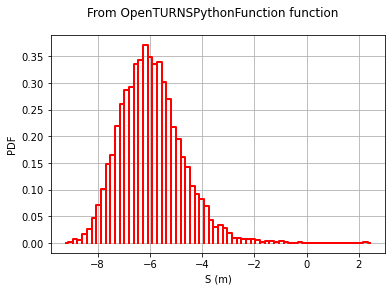

In [15]:
class FloodingClassFunction(ot.OpenTURNSPythonFunction):
    def __init__(self, H_d, Z_b, L, B):
        super(FloodingClassFunction, self).__init__(4, 1)
        self._H_d = H_d
        self._Z_b = Z_b
        self._L = L
        self._B = B
        # Z_d : côte de la digue
        self._Z_d = self._Z_b + self._H_d

    def _exec(self, X):
        Q, K_s, Z_v, Z_m = X
        alpha = (Z_m - Z_v) / self._L
        H = (Q / (K_s * self._B * math.sqrt(alpha))) ** (3.0 / 5.0)
        Z_c = H + Z_v
        S = Z_c - self._Z_d
        return [S]


H_d = 3.0  # Height of the dyke
Z_b = 55.5  # Height of the side of the river
L = 5000.0  # Length of the river
B = 300.0  # Width of the river

myParametricWrapper = FloodingClassFunction(H_d, Z_b, L, B)
myWrapper = ot.Function(myParametricWrapper)

histoGraph = drawHistogram(myWrapper)
histoGraph.setTitle("From OpenTURNSPythonFunction function")
view = otv.View(histoGraph)